# aenet-gpr ASE Calculator Tutorial

This tutorial demonstrates how to use a trained `aenet-gpr` model as an [ASE-calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html) to compute the **energy** and **forces** of an `Atoms` object.

By integrating `aenet-gpr` with `ASE`, you can seamlessly use GPR potentials in your atomistic simulations, just like any other `ASE calculators`.

## Key Features:
- Construct a pre-trained `aenet-gpr` model
- Attach it to an `Atoms` object as a calculator
- Compute total energy and atomic forces

In [1]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [2]:
try:
    import numpy as np
    print("successfully imported numpy")
    print(np.__version__)
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy
1.26.4


In [3]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [4]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 1.8.8
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, chemcoord, dscribe
Required-by: 


In [5]:
import os, sys, site
sys.path.append(site.USER_SITE)

import aenet_gpr
print(aenet_gpr.__version__)

from aenet_gpr.util import ReferenceData
from aenet_gpr.inout import io_train_parameters

1.8.8


# 1. Read reference training/test data from xsf files

We are using train/test HSE06 data of EC dimer prepared in `aenet-gpr/example/2_EC-EC/`

In [6]:
import os.path

! rm -rf 2_EC-EC
! mkdir 2_EC-EC
    
if os.path.isfile("../example/2_EC-EC/train_set_tutorial.zip"):
    ! unzip -oq ../example/2_EC-EC/train_set_tutorial.zip -d ./2_EC-EC/
    print("number of train data:")
    ! find ./2_EC-EC/train_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
    ! unzip -oq train_set_tutorial.zip -d ./2_EC-EC/
    ! rm train_set_tutorial.zip
    print("number of train data:")
    ! find ./2_EC-EC/train_set_tutorial/ -type f | wc -l

--2025-08-02 00:29:29--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip [following]
--2025-08-02 00:29:29--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101063 (99K) [application/zip]
Saving to: ‘train_set_tutorial.zip’

train_set_tutorial. 100%[===================>]  98.69K  --.-KB/s    in 0.002s  

2025

In [7]:
if os.path.isfile("../example/2_EC-EC/test_set_tutorial.zip"):
    ! unzip -oq ../example/2_EC-EC/test_set_tutorial.zip -d ./2_EC-EC/
    print("number of test data:")
    ! find ./2_EC-EC/test_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
    ! unzip -oq test_set_tutorial.zip -d ./2_EC-EC/
    ! rm test_set_tutorial.zip
    print("number of test data:")
    ! find ./2_EC-EC/test_set_tutorial/ -type f | wc -l

--2025-08-02 00:29:50--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip [following]
--2025-08-02 00:29:50--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257174 (251K) [application/zip]
Saving to: ‘test_set_tutorial.zip’

test_set_tutorial.z 100%[===================>] 251.15K  --.-KB/s    in 0.004s  

2025-08

In [8]:
import glob


train_xsf_files = glob.glob("./2_EC-EC/train_set_tutorial/file_*")
train_xsf_files.sort()
train_data = ReferenceData(structure_files=train_xsf_files, file_format='xsf')
train_data.set_data()

print(train_data.energy.shape)
print(train_data.force.shape)

(80,)
(80, 20, 3)


# 2. Model train

In [9]:
train_data.filter_similar_data(threshold=0.2)

In [10]:
if train_data.standardization:
    train_data.standardize_energy_force(train_data.energy)
train_data.config_calculator()

io_train_parameters(data_param=train_data.write_params())

Candidate scales: tensor([0.1000, 0.2000, 0.4000, 0.8000, 1.6000])
Updated scale: 0.4000000059604645
Updated weight: 0.6186434141732067

Training parameters
{'num_data': 80, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000), 'weight': tensor(0.6186, dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(-18637.3499, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['O', 'O', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H'], 'num_atom': 20}



# 3. Evaluation for test set using ASE Calculator

In [11]:
from IPython.display import Image
from aenet_gpr.src import GPRCalculator

In [12]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")
    
    import ase.io
    print("successfully imported ase")

successfully imported ase


In [13]:
test_file = ["./2_EC-EC/test_set_tutorial/file_0000.xsf"]
test_data = ReferenceData(structure_files=test_file, file_format='xsf')

print("Reference DFT energy:", test_data.energy)
print("Reference DFT forces:", test_data.force)

Reference DFT energy: [-18642.26998325]
Reference DFT forces: [[[-1.32399475  2.48303204  0.68777715]
  [-0.92304765  0.84532641  0.14943632]
  [-1.59532558  2.28875072  0.79184903]
  [ 1.83111036  0.67581527 -1.69388758]
  [-0.59484473 -1.36083764  2.77992308]
  [ 2.70840812 -4.16652527 -1.09322984]
  [ 0.38925995 -0.69091849  0.10679783]
  [ 0.15550669 -0.05183078  0.21947315]
  [ 0.02488009 -0.06835778 -1.70333434]
  [-0.70488214  0.06229348 -0.24722831]
  [-0.37657584  0.23076709 -0.69595913]
  [ 2.00728478 -1.58457474  1.09898922]
  [ 0.03323899  2.76811697  1.11335861]
  [ 0.84234494 -1.20868489 -0.06519006]
  [-1.34529812  0.26630821 -1.15616885]
  [-1.28327796 -0.69908103 -1.82330525]
  [-0.06006712 -0.16340475 -0.01420679]
  [ 0.02399728  0.68924761  0.84388794]
  [ 0.28590626  0.52627927 -0.05536857]
  [-0.09462356 -0.84172169  0.75638636]]]


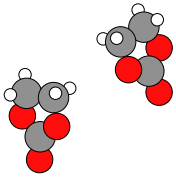

In [14]:
atoms = ase.io.read(test_file[0])
ase.io.write('2EC.png', atoms)
Image("2EC.png")

In [15]:
calc = GPRCalculator(calculator=train_data.calculator, train_data=train_data)

In [16]:
atoms.calc = calc

In [17]:
print("GPR energy prediction:", atoms.get_potential_energy())
print("GPR forces prediction:", atoms.get_forces())

GPR energy prediction: -18642.271676293945
GPR forces prediction: [[-1.44327786  2.0403118   0.76068382]
 [-0.92832032  0.52541287  0.14801361]
 [-1.3822354   1.92371183  0.62928609]
 [ 1.61494168  0.40719759 -1.39069619]
 [-0.76659018 -1.10300898  2.88299683]
 [ 2.76980998 -3.57067717 -1.32389884]
 [ 0.43298679 -0.75462465 -0.02507809]
 [ 0.35188182  0.01834324  0.2577172 ]
 [ 0.1117483  -0.11171649 -1.75128916]
 [-0.61095135 -0.22601051  0.00943377]
 [-0.02921144  0.31584455 -0.57080882]
 [ 2.07229439 -1.95978057  1.29581695]
 [ 0.02629999  2.75466421  1.04074351]
 [ 0.76164859 -1.04149063 -0.185303  ]
 [-1.14850068  0.0931276  -1.29517192]
 [-1.26494617 -0.61253859 -1.96581127]
 [ 0.15588069 -0.13020826 -0.31146732]
 [ 0.17881215  0.64806114  0.92013495]
 [ 0.02080178  0.61827022  0.01910934]
 [-0.12624571 -0.85993428  0.78764098]]


In [18]:
print(np.abs(test_data.force - atoms.get_forces()) > 0.5)

[[[False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False  True False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]
  [False False False]]]
